First, we try things out without transforming the mesh. We want to get rid of the Piola transformations. In the case of a non-transformed mesh this should not make a difference.

We solve the Helmholtz equation using a broken element ansatz, enforcing H(div)-continuity by introducing an additional trace space.

In [1]:
import matplotlib.pyplot as plt
from firedrake import *
import petsc4py.PETSc as PETSc
PETSc.Sys.popErrorHandler()

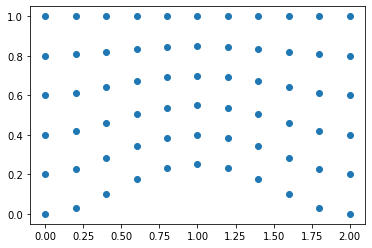

In [2]:
m = IntervalMesh(10,2)
mesh = ExtrudedMesh(m, 5, extrusion_type='uniform')

Vc = mesh.coordinates.function_space()
x, y = SpatialCoordinate(mesh)
f = Function(Vc).interpolate(as_vector([x, y + ( 0.25 * x**4 -x**3 + x**2) * (1-y) ] ) )
mesh.coordinates.assign(f)

xs = [mesh.coordinates.dat.data[i][0] for i in range(0,66)]
ys = [mesh.coordinates.dat.data[i][1] for i in range(0,66)]

plt.scatter(xs, ys)


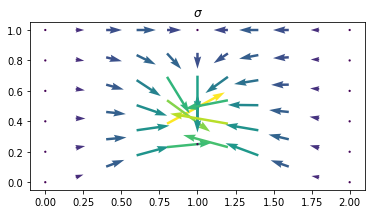

In [4]:
element = FiniteElement("RTCF", cell="quadrilateral", degree=1)
element._mapping = 'identity'
Sigma = FunctionSpace(mesh, element)
V = FunctionSpace(mesh, "DG", 0)

W = Sigma * V

#############define problem ########################################################
sigma, u = TrialFunctions(W)
tau, v = TestFunctions(W)

#boundary conditions sigma dot n = 0 everywhere:
bc0 = DirichletBC(W.sub(0), as_vector([0.0, 0.0]), "bottom")
bc1 = DirichletBC(W.sub(0), as_vector([0.0, 0.0]), "top")
bc2 = DirichletBC(W.sub(0), as_vector([0.0, 0.0]), 1)
bc3 = DirichletBC(W.sub(0), as_vector([0.0, 0.0]), 2)

#force term
x, y = SpatialCoordinate(mesh)
f = 10*exp(-100*((x - 1)**2 + (y - 0.5)**2))

#set up variational problem
a = dot(sigma, tau)*dx  + div(tau)*u*dx + div(sigma)*v*dx + v*u*dx
L = -f*v*dx

#will be the solution
wh = Function(W)

#solve

parameters = {"ksp_type":"gmres", "ksp_monitor":None, "pc_type":"lu", "mat_type":"aij","pc_factor_mat_solver_type":"mumps" }

solve(a == L, wh, bcs=[bc0, bc1, bc2, bc3], solver_parameters=parameters)

sigmah, uh = wh.split()

#output/plot solution
file0 = File("testPiola.pvd")
file0.write(sigmah, uh)

fig, axes = plt.subplots()
quiver(sigmah, axes=axes)
axes.set_aspect("equal")
axes.set_title("$\sigma$")
plt.show()



In [4]:
CG_1 = FiniteElement("CG", interval, 1)
DG_0 = FiniteElement("DG", interval, 0)
P1P0 = TensorProductElement(CG_1, DG_0)
#RT_horiz = HDivElement(P1P0)
RT_horiz = P1P0

P0P1 = TensorProductElement(DG_0, CG_1)
#RT_vert = HDivElement(P0P1)
RT_vert = P0P1
#element = RT_horiz + RT_vert
#element.mapping() = "identity"
#element = P1P0 + P0P1

Sigma_horiz = FunctionSpace(mesh, RT_horiz)
Sigma_vert = FunctionSpace(mesh, RT_vert)
#Sigma = FunctionSpace(mesh, element)
V = FunctionSpace(mesh, "DG", 0)




Find $(\sigma, u, \lambda)$ in $\hat{\Sigma} \times V \times T$ such that 

$$
\begin{align}
\int_\Omega (\sigma \cdot \tau + \nabla \cdot \tau u)\,\text{d} x + \langle [[ \tau ]], \lambda \rangle_{\partial \mathcal{T}_h \setminus \Gamma_D} &= 
  \int_\Gamma \tau \cdot n u\,\text{d}s \quad \forall \tau \in \hat{\Sigma}\\ 
\int_\Omega (\nabla\cdot\sigma)v + v u\,\text{d} x &= - \int_\Omega f v\,\text{d}x 
\quad \forall v \in V\\
\langle \gamma, [[ \sigma ]] \rangle_{\partial \mathcal{T}_h \setminus \Gamma_D} &= \langle \gamma, g \rangle_{\Gamma_N}\quad \forall \gamma \in T
\end{align}
$$

In our implementation we solve subject to the BC $\sigma \cdot n = 0$:

In [5]:
Sigmahat_horiz = FunctionSpace(mesh, BrokenElement(Sigma_horiz.ufl_element())) # do I need broken element here??
Sigmahat_vert = FunctionSpace(mesh, BrokenElement(Sigma_vert.ufl_element()))
V = FunctionSpace(mesh, V.ufl_element())
T = FunctionSpace(mesh, FiniteElement("HDiv Trace", mesh.ufl_cell(), degree = 0))
W_hybrid = Sigmahat_horiz * Sigmahat_vert * V * T

n = FacetNormal(mesh)

sigmahat_horiz, sigmahat_vert, uhat, lambdar = TrialFunctions(W_hybrid)
tauhat_horiz, tauhat_vert, vhat, gammar = TestFunctions(W_hybrid)

sigmahat = as_vector([0,1])*sigmahat_vert + as_vector([1,0])*sigmahat_horiz
tauhat = as_vector([0,1])*tauhat_vert + as_vector([1,0])*tauhat_horiz

wh = Function(W_hybrid)

f = 10*exp(-100*((x - 1)**2 + (y - 0.5)**2))

a_hybrid = ( inner(sigmahat, tauhat)*dx + div(tauhat)*uhat*dx + div(sigmahat)*vhat*dx +vhat*uhat*dx
            + inner(tauhat, n)*lambdar*( ds_b + ds_t + ds_v)
            + inner(sigmahat, n)*gammar* (ds_b + ds_t+ ds_v) 
            + jump(tauhat, n=n)*lambdar('+')*(dS_h + dS_v)
            + jump(sigmahat, n=n)*gammar('+')* (dS_h + dS_v)) 
                                                                   
L = -f*vhat*dx

#will be the solution
wh = Function(W_hybrid)

#solve

parameters = {"ksp_type":"gmres", "ksp_monitor":None, 
              "pc_type":"lu", "mat_type":"aij",
              "pc_factor_mat_solver_type":"mumps" }


In [6]:
solve(a_hybrid == L, wh, bcs = [], solver_parameters=parameters)

Text(0.5, 1.0, '$\\sigma$')

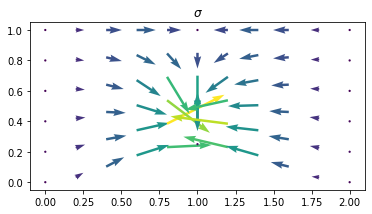

In [7]:
sigmah_horiz, sigmah_vert, uh, lambdah = wh.split()
sigmah = as_vector([0,1])*sigmah_vert + as_vector([1,0])*sigmah_horiz
V_plot = VectorFunctionSpace(mesh, "DG", 0)
sigmah_plot = Function(V_plot).interpolate(sigmah)

#output/plot solution
file0 = File("test.pvd")
#can't write sigmah to file???
file0.write(sigmah_plot,uh)
fig, axes = plt.subplots()
quiver(sigmah, axes=axes)
axes.set_aspect("equal")
axes.set_title("$\sigma$")


Warum sind die Farben anders???

### hybridized with SCPC

In [9]:

scpc_parameters = {"ksp_type":"preonly", "pc_type":"lu"}

solve(a_hybrid == L, wh, solver_parameters = {"ksp_type": "gmres","mat_type":"matfree", 
                                              "pc_type":"python", "pc_python_type":"firedrake.SCPC", 
                                              "condensed_field":scpc_parameters, 
                                              "pc_sc_eliminate_fields":"0,1,2"})


NotImplementedError: Only supports up to three function spaces.

In [ ]:
sigmah, uh, lamdah = wh.split()

file2 = File("testHybrid.pvd")
file2.write(sigmah, uh)

fig, axes = plt.subplots()

quiver(sigmah, axes=axes)
axes.set_aspect("equal")
axes.set_title("$\sigma$")

### hybridized with HybridizationPC

In [ ]:
hybrid_parameters = {'ksp_type': 'preonly',
                     'mat_type': 'matfree',
                     'pc_type': 'python',
                     'pc_python_type': 'firedrake.HybridizationPC',
                     # Solver for the trace system
                     'hybridization': {'ksp_type': 'gmres',
                                       'pc_type': 'gamg',
                                       'pc_gamg_sym_graph': True,
                                       'ksp_rtol': 1e-7,
                                       'mg_levels': {'ksp_type': 'richardson',
                                                     'ksp_max_it': 5,
                                                     'pc_type': 'bjacobi',
                                                     'sub_pc_type': 'ilu'}}}

In [ ]:
W = Sigma_horiz * Sigma_vert * V

sigma_horiz, sigma_vert, u = TrialFunctions(W)
tau_horiz, tau_vert, v = TestFunctions(W)

sigma = as_vector([0,1])*sigma_vert + as_vector([1,0])*sigma_horiz
tau = as_vector([0,1])*tau_vert + as_vector([1,0])*tau_horiz



#boundary conditions_ Neumann at top and bottom for sigma=W.sub(0)

#how do I implent BC on deformed mesh????

bc0 = DirichletBC(W.sub(1), 0, "bottom") ##in undeformed grid these are the normal components
bc1 = DirichletBC(W.sub(1), 0, "top")

#force term
x, y = SpatialCoordinate(mesh)
f = 10*exp(-100*((x - 1)**2 + (y - 0.5)**2))

#set up variational problem
a = dot(sigma, tau)*dx  + div(tau)*u*dx + div(sigma)*v*dx + u*v*dx
L = -f*v*dx

#will be the solution
wh = Function(W)

In [ ]:
problem = LinearVariationalProblem(a, L, wh, bcs=[bc0,bc1])

solver = LinearVariationalSolver(problem, solver_parameters=hybrid_parameters)

In [ ]:
solver.solve()